<a href="https://colab.research.google.com/github/Javier1224/Reconocimiento_Leucemia/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se cargan las librerías a utilizar durante el desarrollo del proyecto

In [32]:
from IPython import get_ipython
from IPython.display import display
# %%
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
import os

import skimage
import skimage.color as skic # operaciones con color
from skimage.color import rgb2gray # Importar rgb2gray
import skimage.filters as skif # filtros
import skimage.util as sku # utilidades
import skimage.metrics as skm # métricas
from skimage import segmentation as seg # Segmentación
import skimage.io as skio

from skimage.exposure import histogram
from skimage.transform import resize
from skimage import img_as_float, exposure
from skimage.feature import hog
#from skimage.feature import greycomatrix, greycoprops
from skimage import color, data, transform
from skimage.feature import canny

  # Importar skimage.io para cargar la imagen
import matplotlib.image as mpimg
import cv2





Se recupera la información de la base de datos desde el repositorio

In [45]:
!wget -q https://github.com/Javier1224/Reconocimiento_Leucemia/releases/download/Eliza/Datos.zip
!unzip -q Datos.zip

Se crean las funciones necesarias para manipular la información

In [37]:
#Funcion para mostrar la imagen
def cargar_imagenes_por_carpeta(ruta):
  images = []
  labels = []
  for filename in os.listdir(ruta):
      if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
          image_path = os.path.join(ruta, filename)
          image = skio.imread(image_path)
          images.append(image)

          # Extraer etiqueta desde el nombre de archivo (hasta el primer guión bajo por ejemplo)
          label = filename.split('.')[0]
          labels.append(label)
  return images

def show(img):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img, cmap=plt.cm.gray) # usar pyplot biultin colormap gray
    ax.set_axis_off()
    plt.show()

def show_images_side_by_side(images, names):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 8, 8))

    for index, (img, name) in enumerate(zip(images, names)):
        axes[index].imshow(img, cmap=plt.cm.gray)
        axes[index].set_title(name)

    plt.show()

def linear_contrast_adjustment(image, min_intensity, max_intensity):
    # Ajusta el contraste linealmente
    adjusted_image = np.clip((image - min_intensity) * (255.0 / (max_intensity - min_intensity)), 0, 255)
    return adjusted_image.astype(np.uint8)

def showPair(image1, image2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image1, cmap='gray')
    ax1.axis('off')
    ax1.set_title('Imagen')
    ax2.imshow(image2, cmap='gray')
    ax2.axis('off')
    ax2.set_title('Imagen con bordes')
    plt.show()

def aplicar_espejo(imagen):
    return imagen.transpose(Image.FLIP_LEFT_RIGHT)

def crear_directorio(ruta):
    if not os.path.exists(ruta):
        os.makedirs(ruta)

# Mínimo requerido de imágenes de entrenamiento
minimo_entrenamiento = 458

Funciones para realizar data augmentation

In [38]:
def augmentar_imagen(imagen):
    """
    Aplica una transformación aleatoria a la imagen: rotación o reflejo.
    """
    transformacion = random.choice(['rot90', 'rot180', 'rot270', 'flip_h', 'flip_v'])
    if transformacion == 'rot90':
        return cv2.rotate(imagen, cv2.ROTATE_90_CLOCKWISE)
    elif transformacion == 'rot180':
        return cv2.rotate(imagen, cv2.ROTATE_180)
    elif transformacion == 'rot270':
        return cv2.rotate(imagen, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif transformacion == 'flip_h':
        return cv2.flip(imagen, 1)  # horizontal
    elif transformacion == 'flip_v':
        return cv2.flip(imagen, 0)  # vertical

def balancear_clases(carpetaRaiz):
    """
    Recibe una lista de tuplas (una por clase) y aplica data augmentation
    para igualar la cantidad de imágenes de todas las clases.
    """
    max_largo = max(len(clase) for clase in carpetaRaiz)
    carpetaRaiz_aug = []

    for clase in carpetaRaiz:
        clase_aug = list(deepcopy(clase))  # copia original
        faltantes = max_largo - len(clase)

        if faltantes > 0:
            for _ in range(faltantes):
                imagen_original = random.choice(clase)
                imagen_transformada = augmentar_imagen(imagen_original)
                clase_aug.append(imagen_transformada)

        carpetaRaiz_aug.append(tuple(clase_aug))  # conserva tipo tupla

    return carpetaRaiz_aug

Ahora, se debe cargar las rutas desde las cuales cargar los datos a variables en python con las que poder trabajar

In [50]:
# Se cargar cada carpeta de imagenes en una variable en particular
Benign = "/content/Original/Benign"
Early = "/content/Original/Early"
Pro = "/content/Original/Pre"
Pre = "/content/Original/Pro"

celulas = [Benign,Early,Pro,Pre]
celulasTag = ["Benign","Early","Pro","Pre"]
carpetaRaiz = []
for ruta in celulas:
  carpetaRaiz.append(tuple(cargar_imagenes_por_carpeta(ruta)))

for i in range(len(carpetaRaiz)):
  print(f'La cantidad de imagenes de {celulasTag[i]} es {len(carpetaRaiz[i])}')

La cantidad de imagenes de Benign es 504
La cantidad de imagenes de Early es 985
La cantidad de imagenes de Pro es 963
La cantidad de imagenes de Pre es 804


Se aplica el balanceo de carga en base a aplicar transformaciones de rotación de 90 grados y reflexión de las imágenes

In [51]:
carpetaRaiz_aug = balancear_clases(carpetaRaiz)
# Verifica longitudes
for i, clase in enumerate(carpetaRaiz_aug):
    print(f"Categoría {celulasTag[i]} ahora tiene: {len(clase)} imágenes")

Categoría Benign ahora tiene: 985 imágenes
Categoría Early ahora tiene: 985 imágenes
Categoría Pro ahora tiene: 985 imágenes
Categoría Pre ahora tiene: 985 imágenes


Se realiza el proceso de preprocesamiento de información:

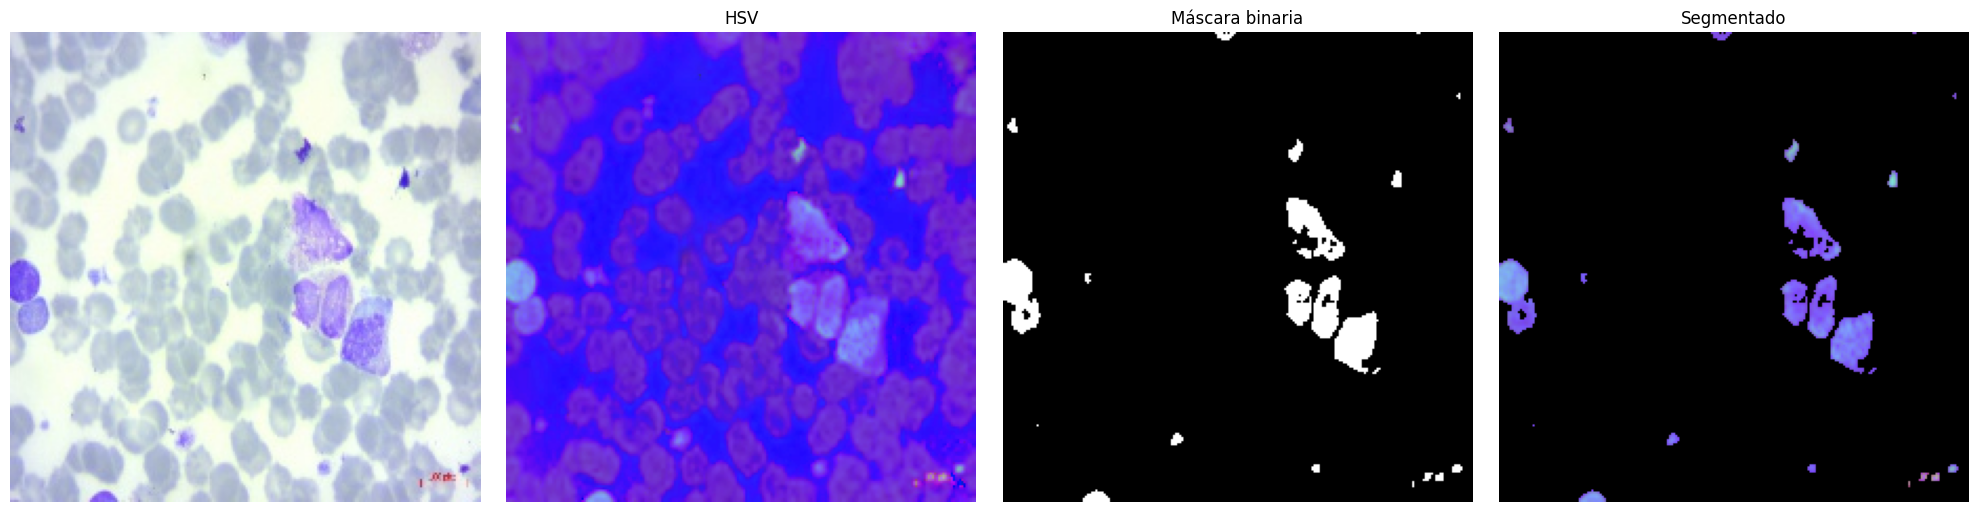

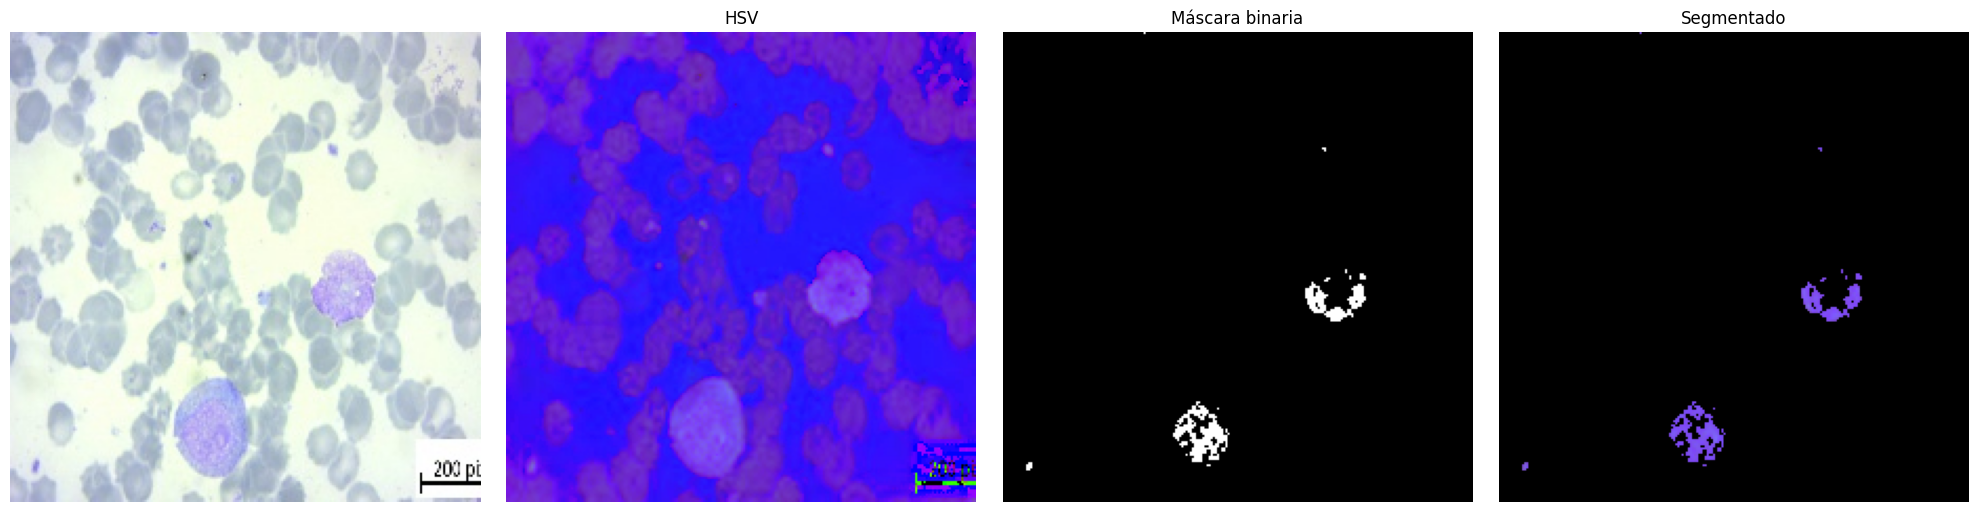

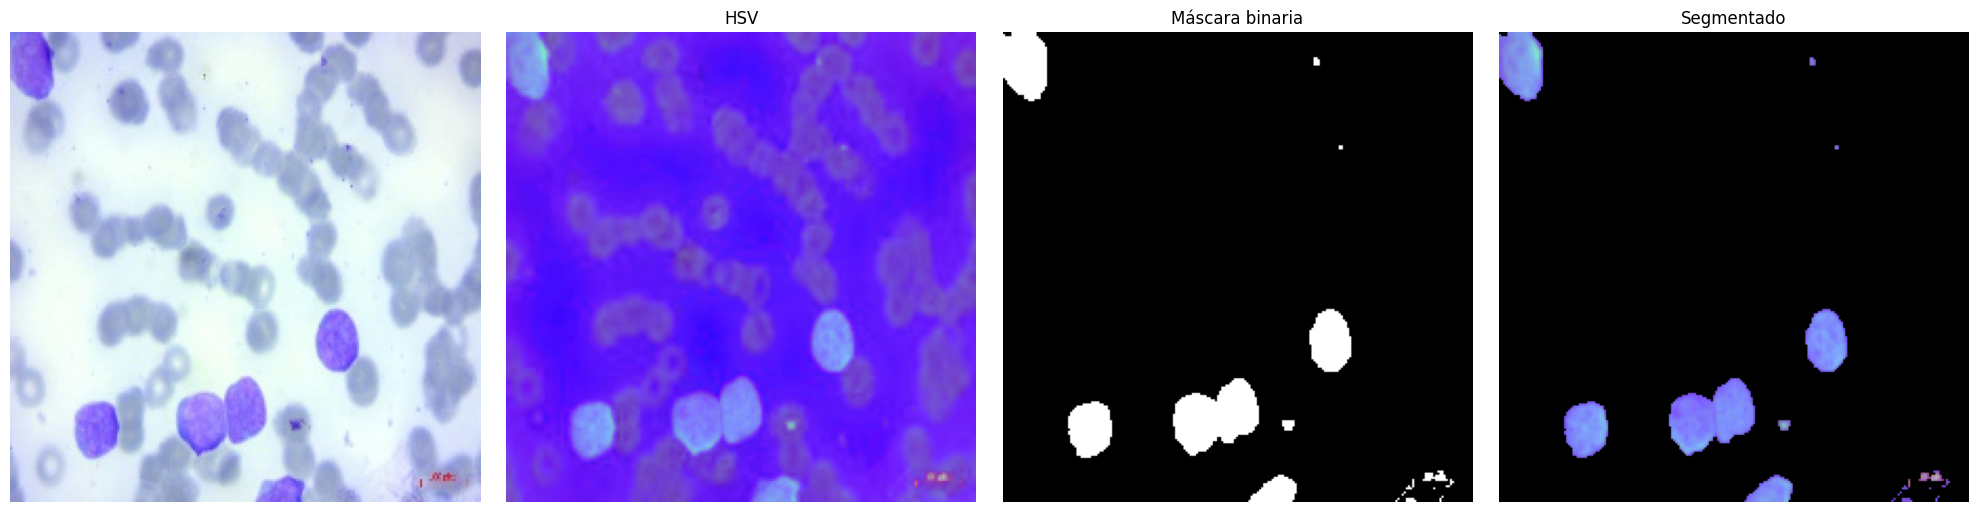

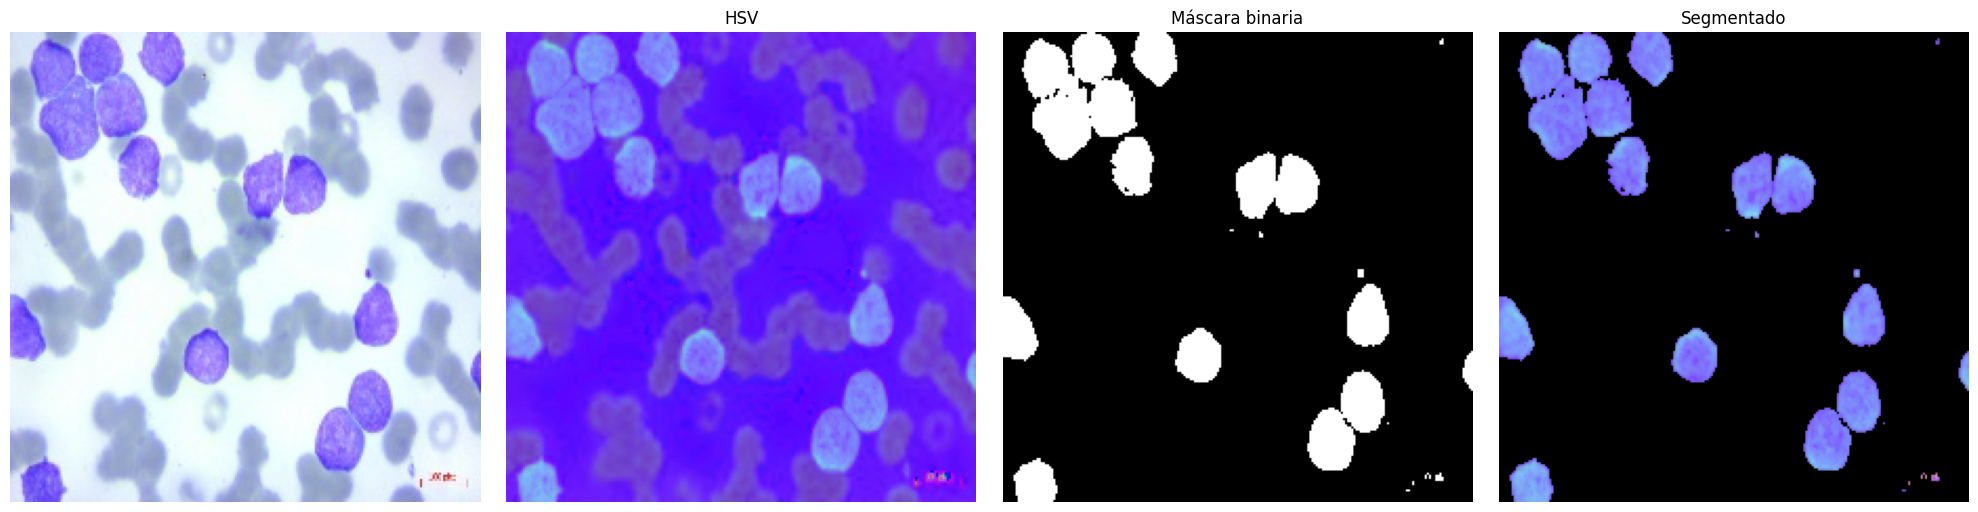

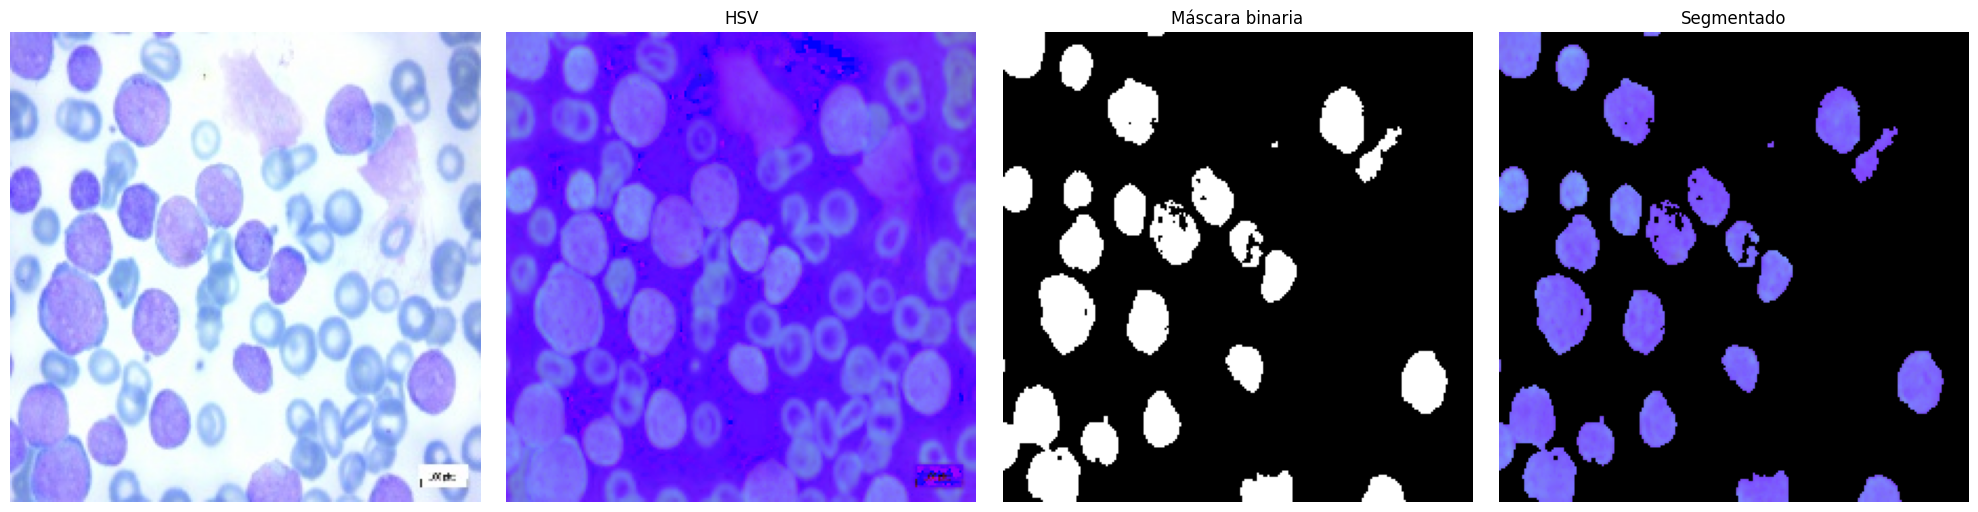

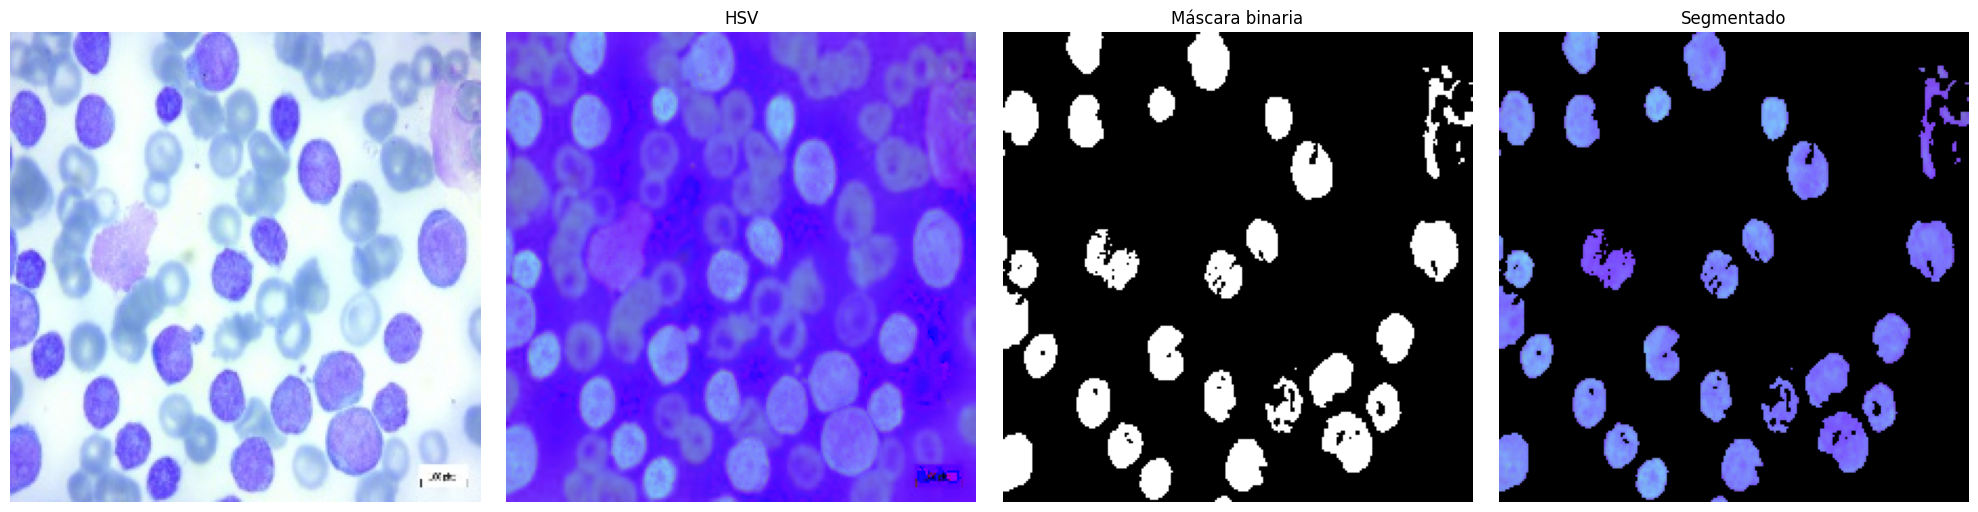

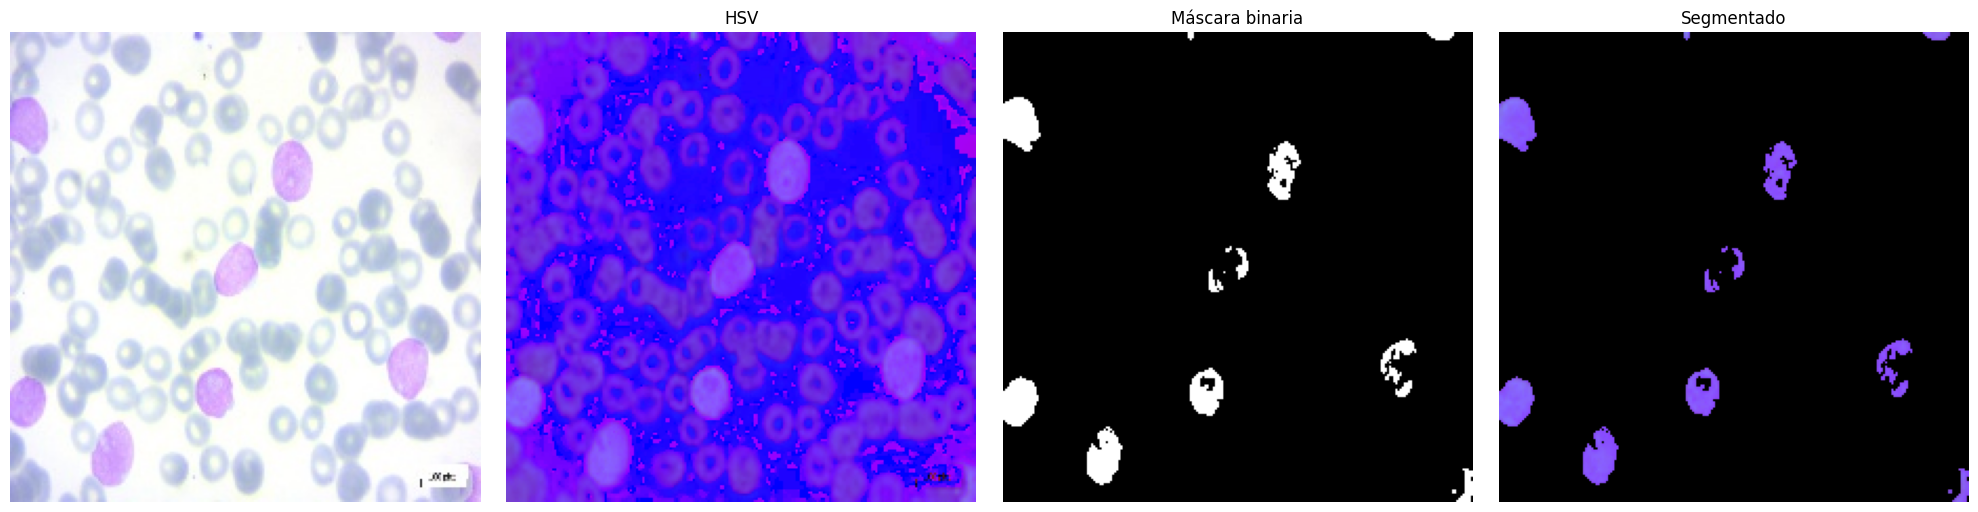

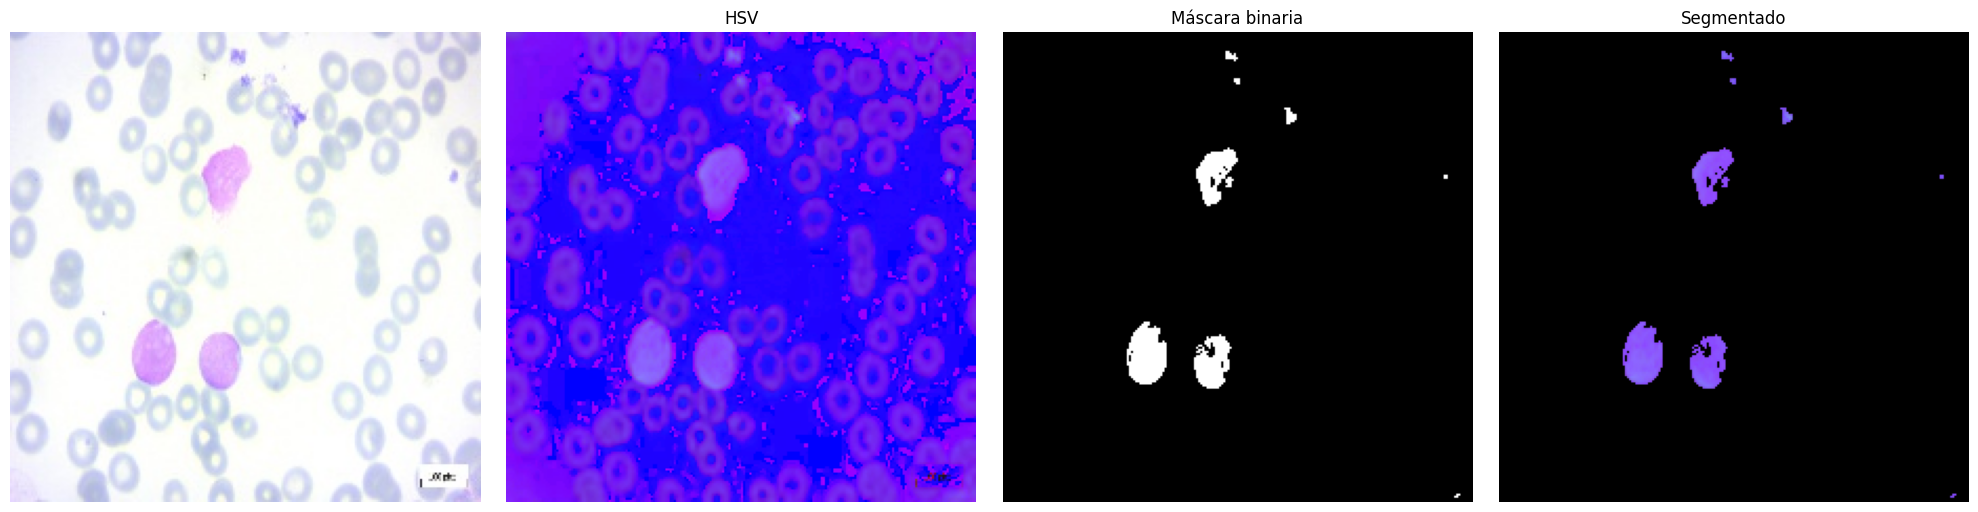

In [60]:
CarpetaRaiz_Preprocesada = []
for folder in range(len(carpetaRaiz_aug)):
  images = carpetaRaiz_aug[folder]
  images_preprocesadas = []
  cant_muestras_sh = 0
  for i in range(0,len(images)):
    # Convertir a HSV
    img_rgb = images[i]
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    # Filtro Gaussiano
    imgFlotante = img_as_float(img_hsv)
    #filtered_image = skif.gaussian(image=imgFlotante, sigma = 0.1)

    # Definir el rango de color que quieres segmentar (ajusta según tu caso)
    lower = np.array([120, 70, 70])
    upper = np.array([180, 255, 255])

    # Crear máscara binaria
    #mask = cv2.inRange(filtered_image, lower, upper)
    mask = cv2.inRange(img_hsv, lower, upper)

    # Aplicar máscara sobre la imagen original
    #segmented = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
    segmented = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)
    images_preprocesadas.append(segmented)

    if cant_muestras_sh < 2:
      # Mostrar resultados
      fig, axs = plt.subplots(1, 4, figsize=(20, 5))
      axs[0].imshow(img_rgb)
      #
      #axs[0].set_title(filename.split('.')[0])
      axs[1].imshow(img_hsv)
      axs[1].set_title("HSV")
      axs[2].imshow(mask, cmap='gray')
      axs[2].set_title("Máscara binaria")
      axs[3].imshow(segmented)
      axs[3].set_title("Segmentado")
      for ax in axs:
          ax.axis('off')
      plt.tight_layout()
      plt.show()
    cant_muestras_sh += 1

  CarpetaRaiz_Preprocesada.append(tuple(images_preprocesadas))

Utilizar la siguiente instrucción para hacer pruebas y mostrar imágenes

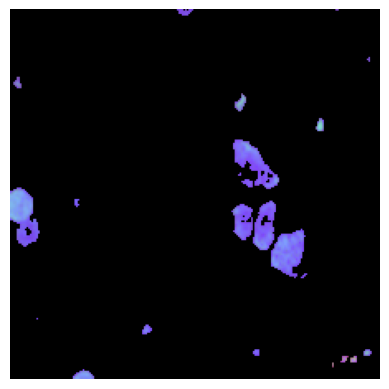

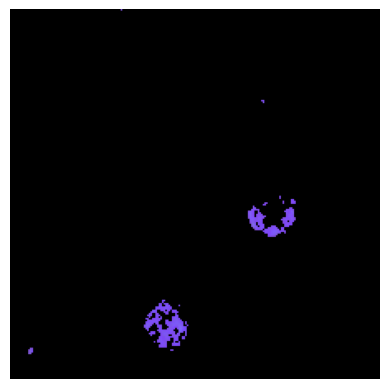

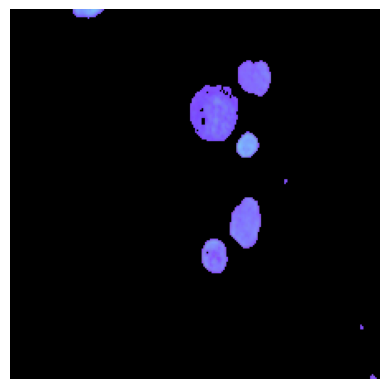

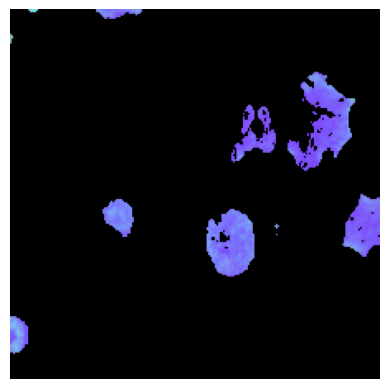

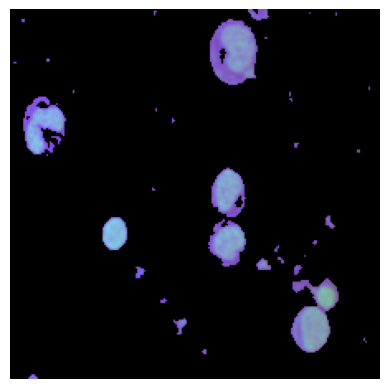

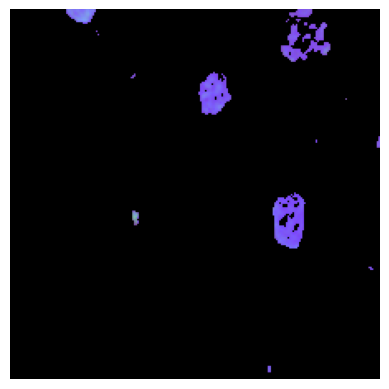

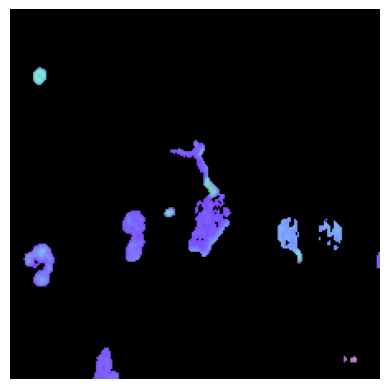

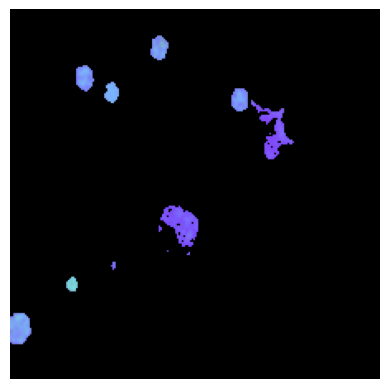

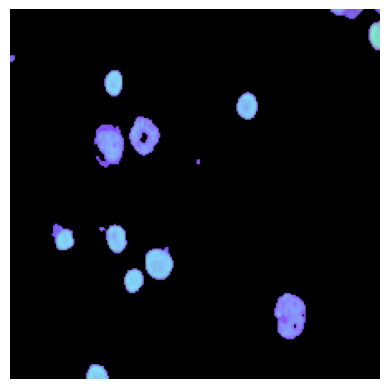

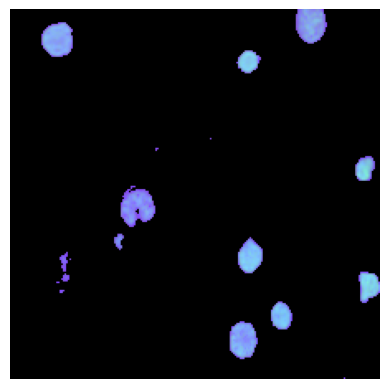

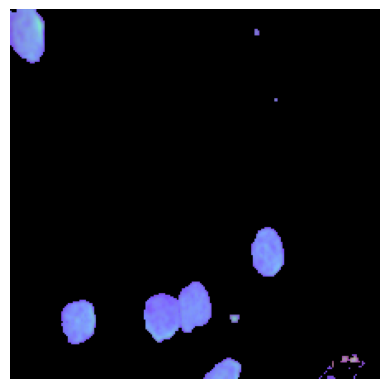

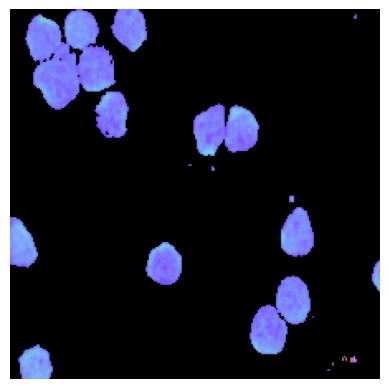

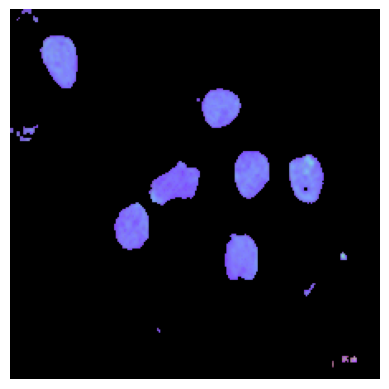

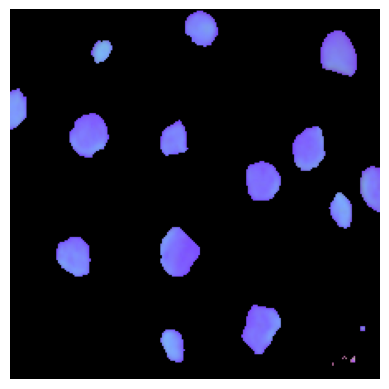

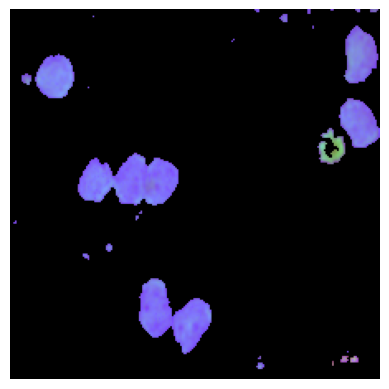

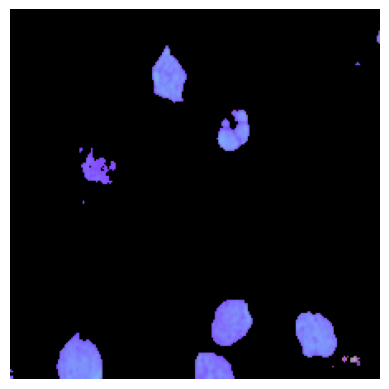

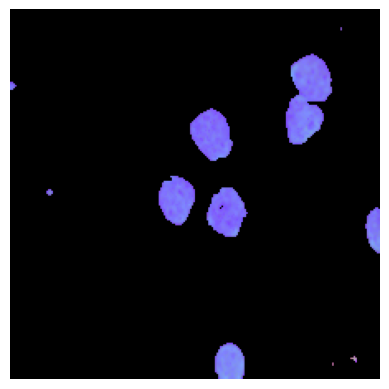

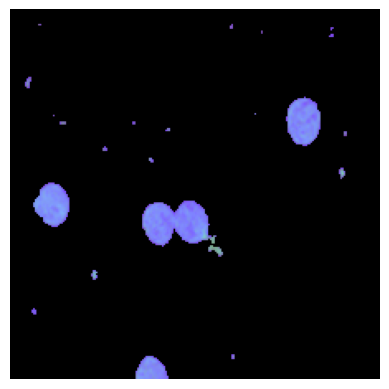

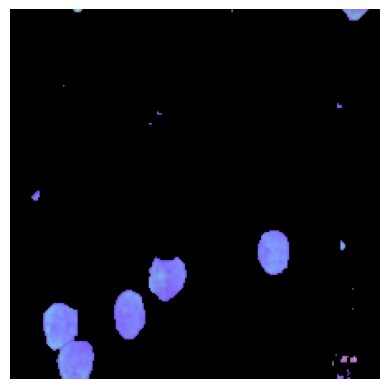

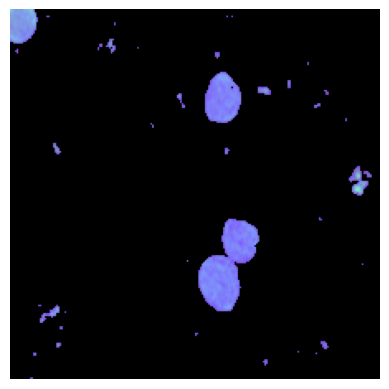

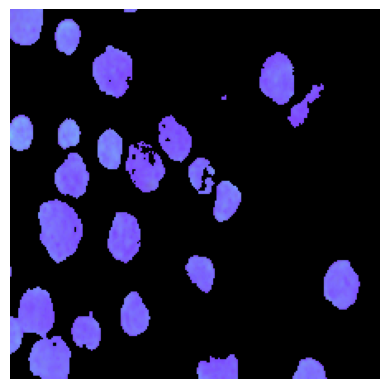

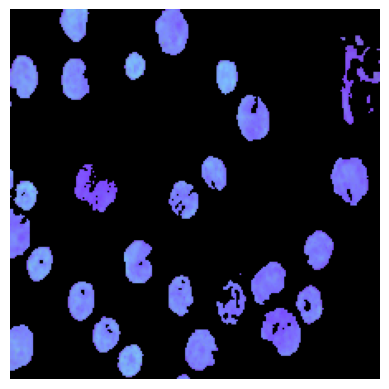

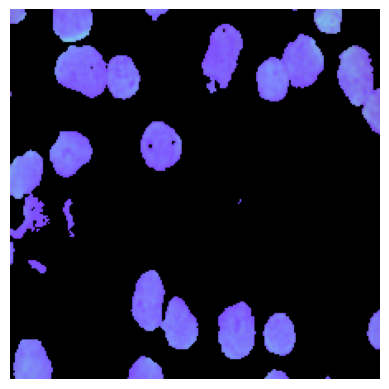

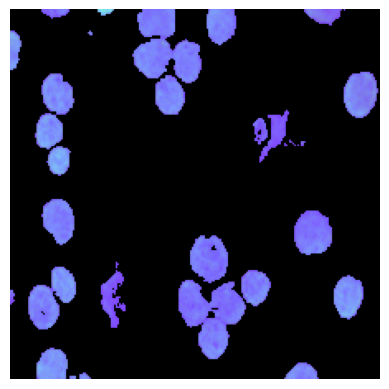

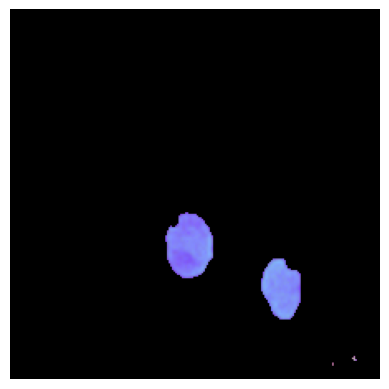

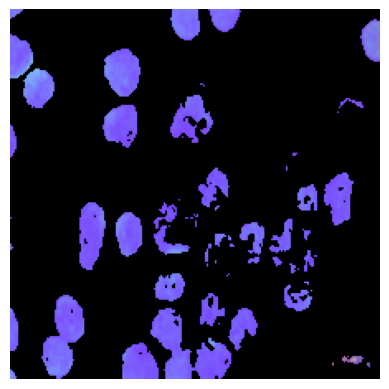

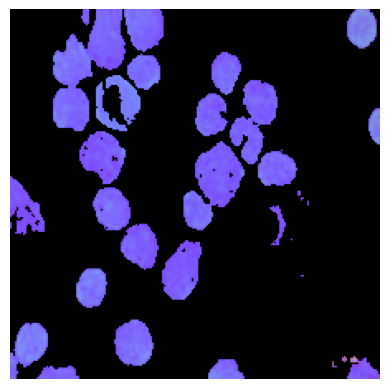

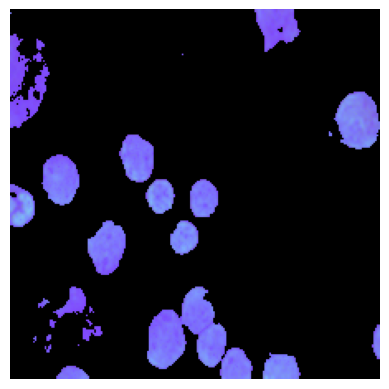

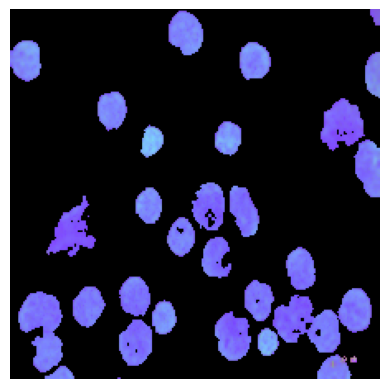

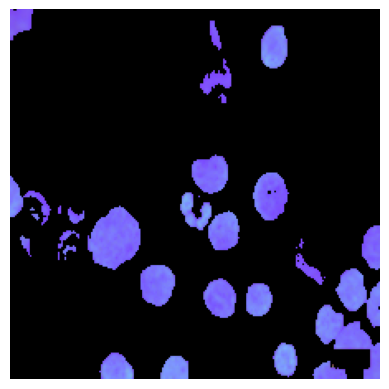

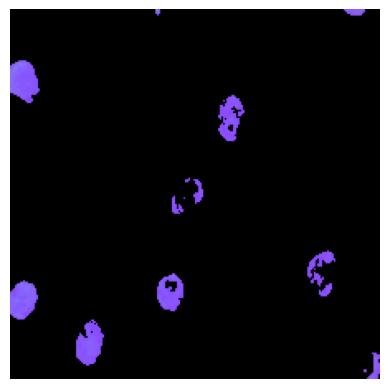

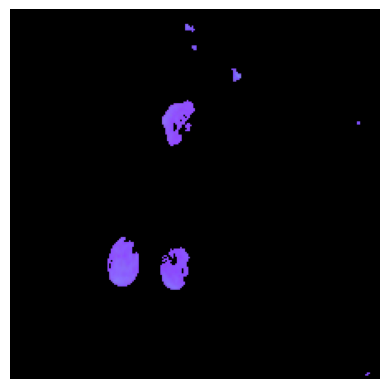

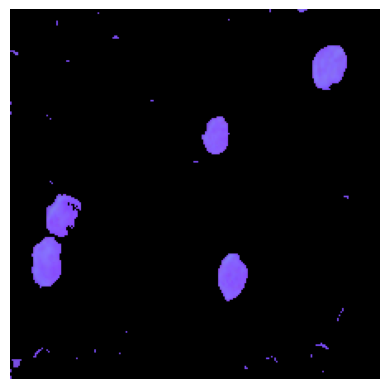

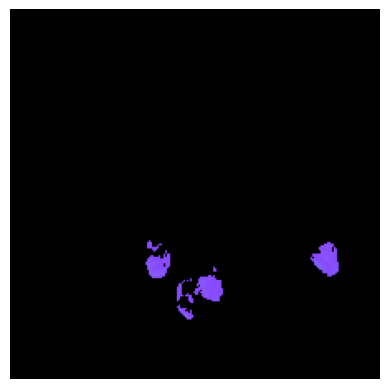

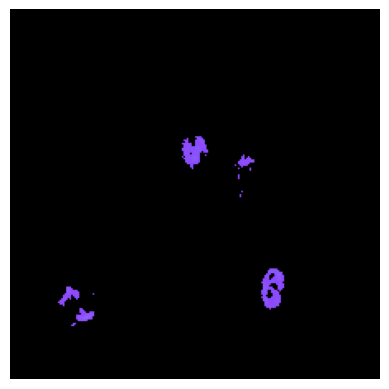

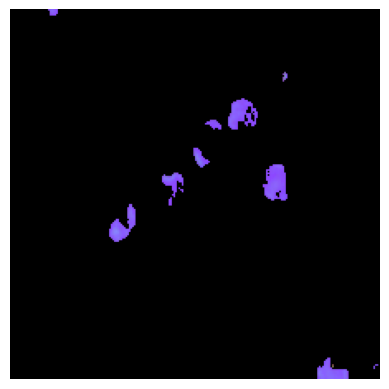

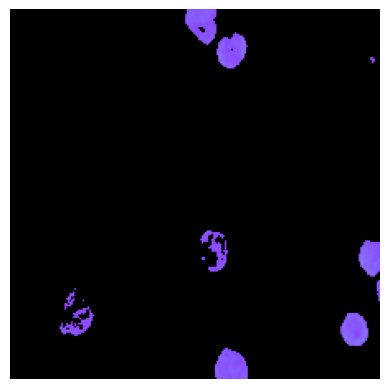

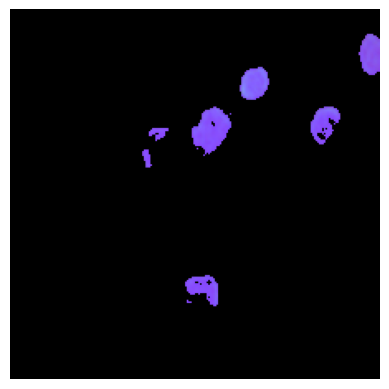

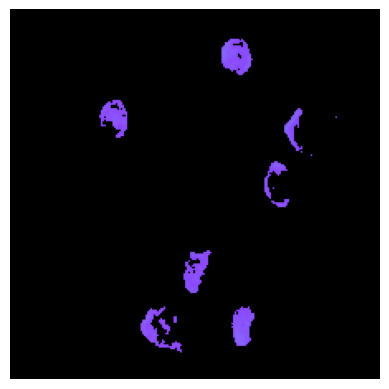

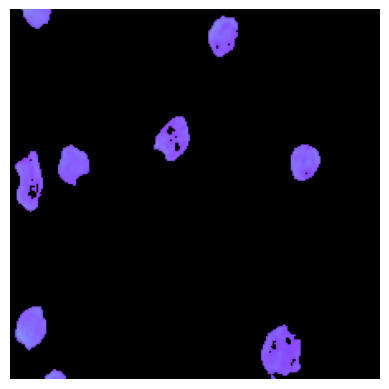

In [57]:
# Cargar imágenes de una carpeta (por ejemplo, Benign)
#imagenes_benignas = cargar_imagenes_por_carpeta("/content/Original/Benign")
muestras_por_folder = 10

for folder in range(len(CarpetaRaiz_Preprocesada)):
  #print(f'La cantidad de imagenes de {celulasTag[folder]} es {len(CarpetaRaiz_Preprocesada[folder])}'
  for muestra in range(10):
    plt.imshow(CarpetaRaiz_Preprocesada[folder][muestra])
    plt.axis('off')  # Ocultar los ejes
    plt.show()
    print(" ")